# Миграция в обратном времени (RTM)

## 1. Подготовка к расчётам

Это упражнение будет полностью основываться на упражнении по конечно-разностному моделированию волнового поля. Перед началом рекомендуется пробежаться глазами по тому примеру и восстановить все в памяти.

Нет, серьезно. Надо.

Если там все ясно, то это упражнение можно смело пролистывать вниз до пункта 3.
Пункты 1-2 этого упражнения повторяют все действия из того примера практически дословно, но сжато. И в скоростной модели добавился еще один дифрактор. Для красоты.

#### 1.0. Импорт стандартных библиотек

In [1]:
from __future__ import division
import numpy as np
from bruges.filters.wavelets import ricker
import matplotlib.pyplot as plt
from scipy.signal import convolve
import skimage.filters

#### 1.1. Задаем сетку, шаги по x и по y, шаг по времени

In [2]:
dt = 1e-4 #seconds
dx = 1    #meters
dz = 1    #meters

#Size of model in meters
nx = 100
nz = 80

tmax = 0.1 #seconds
t_array = np.arange(0, tmax, dt) #array of times

#### 1.2. Задаем скоростную модель: граница на глубине 50 м, дифрактор над ней

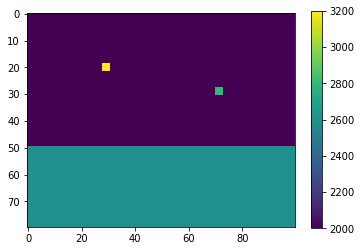

In [3]:
vp = 2000.0     #m/s
vmodel = vp * np.ones((nx, nz), dtype = float)

vmodel[:, 50:] = vp*1.3
vmodel[70:73, 28:31] = vp*1.4
vmodel[28:31, 19:22] = vp*1.6

im_v = plt.imshow(vmodel.T)
plt.colorbar()
plt.show()


#### 1.3. Задаем импульс

функция для импульса рикера импортируется из внешней библиотеки bruges

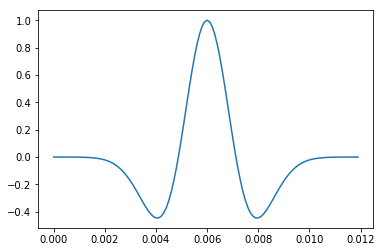

In [4]:
wav1 = ricker(duration = 0.012, dt = dt, f = 200)
plt.plot(np.arange(0, 0.012, dt), wav1)
plt.show()

#### 1.4. Задаем позицию источника

In [5]:
isx = 50
isz = 0

## 2. Расчёт прямой задачи (моделирование волнового поля)

Для расчётов используем функцию `solve_fd2d_abc`, рассчитывающую волновое поле на следующем шаге по значениям на двух предыдущих шагах в модели с поглощающими границами.

In [6]:
def solve_fd2d_abc(v, w, vmodel, r, dt, dx, dz):
    """
    Compute wave amplitude at the next k-th time step
    with boundary conditions
    
    v = snapshot of amplitude at last step (k-1)
    w = snapshot of amplitude at previous step (k-2).
    """
    
    D = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    u_out = 2*v - 1*w + (r**2)*convolve(v, D, mode='same')
    
    #bottom
    u_out[:,-1] = v[:,-2] + (r[:,-1] - 1)/(r[:,-1] + 1)*(u_out[:,-2] - v[:,-1])
    #right
    u_out[-1,:] = v[-2,:] + (r[-1,:] - 1)/(r[-1,:] + 1)*(u_out[-2,:] - v[-1,:])
    #left
    u_out[0,:] = v[1,:] + (r[0,:] - 1)/(r[0,:] + 1)*(u_out[1,:] - v[0,:])
    
    return u_out

Пусть u_abc будет 3Д массивом с амплитудами волнового поля. Пошагово заполним его, не забывая про источник.

In [8]:
u_abc = np.zeros((np.shape(vmodel)[0], np.shape(vmodel)[1], int(tmax/dt)), dtype = float)
r = vmodel*dt/dx

for k, tk in enumerate(t_array):
    if k >= 2: # we need to start from step 2 because step 1 and step 0 are initial conditions
        v = u_abc[:,:,k-1]
        w = u_abc[:,:,k-2]
        
        u = solve_fd2d_abc(v, w, vmodel, r, dt, dx, dz)

        if k < len(wav1): # if source is active, add its amplitudes to the wavefield
            u[isx, isz] = u[isx, isz] + wav1[k]

        u_abc[:,:,k] = u


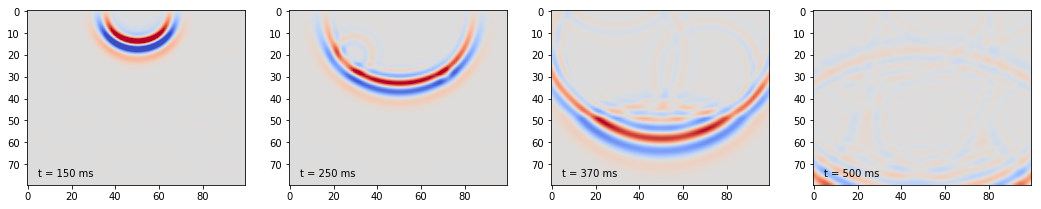

In [9]:
iterations_to_show = [150, 250, 370, 500]

fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
for j, ax in enumerate(axs):
    ax.imshow(u_abc[:, :, iterations_to_show[j]].T, cmap = 'coolwarm_r', vmin = -1, vmax = 1, interpolation='bilinear')
    ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
plt.show()

Ну и покажем еще раз сейсмограмму $u_{abc}(x,0,t)$:

In [10]:
surface_record_raw = u_abc[:,1,:]

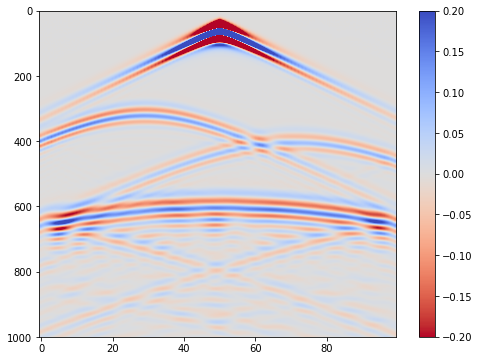

In [15]:
#display

fgr2, axs2 = plt.subplots(1,1, figsize = (8,6))
im1=axs2.imshow(surface_record_raw.T, cmap = 'coolwarm_r', vmin = -0.2, vmax = 0.2, interpolation='bilinear', aspect='auto')
fgr2.colorbar(im1, ax = axs2)
plt.show()

Ок, закончили с подготовкой

## 2. Предобработка

Конечно, чересчур громкое название для простого верхнего мьютинга. Он нужен, чтобы вырезать с сейсмограммы прямую волну и оставить только полезный сигнал.

#### 2.1. Верхний мьютинг

Выполним два шага: 
1. Рассчитаем времена пробега прямой волны $t_П = x/v$; 
2. Все отсчёты на сейсмограмме, у которых для данного $x$ время меньше чем $t_П$, зануляем.

Компенсацию за сферическое расхождение выполнять не будем.

In [16]:
#Top muting
muted_gather = surface_record_raw.copy()
x_array = np.arange(0, nx*dx, dx)
v0 = vmodel[:,0]
traveltimes = abs(np.cumsum(dx/v0) - np.cumsum(dx/v0)[isx])
for traceno in xrange(len(x_array)):
    muted_gather[traceno, 0:int(traveltimes[traceno]/dt  + len(wav1))] = 0 
    

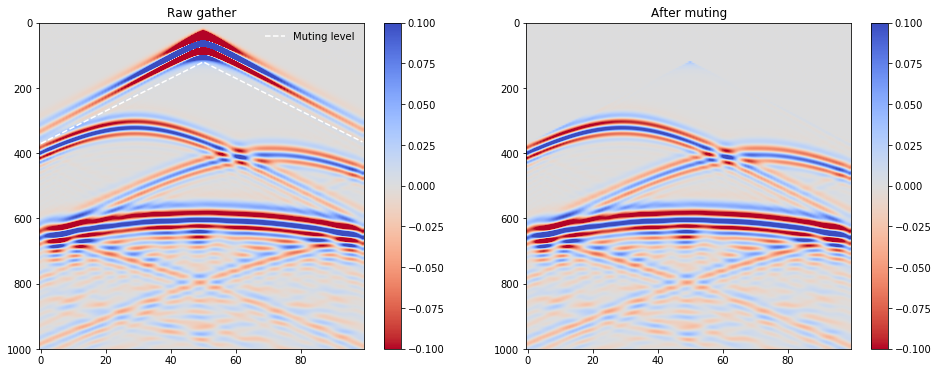

In [17]:
#display
fgr3, axs3 = plt.subplots(1, 2, figsize = (16,6))

axs3[0].set_title('Raw gather')
im3=axs3[0].imshow(surface_record_raw.T, cmap = 'coolwarm_r', vmin = -0.1, vmax = 0.1, interpolation='bilinear', aspect='auto')
axs3[0].plot(traveltimes/dt  + len(wav1), c='w', ls='--', label = 'Muting level')
axs3[0].legend(framealpha = 0.0)
fgr3.colorbar(im3, ax = axs3[0])

axs3[1].set_title('After muting')
im4=axs3[1].imshow(muted_gather.T, cmap = 'coolwarm_r', vmin = -0.1, vmax = 0.1, interpolation='bilinear', aspect='auto')
fgr3.colorbar(im4, ax = axs3[1])

plt.show()

По традиции, запилим Агутина.

![](http://risovach.ru/upload/2018/01/mem/otchayannyy-agutin_167216126_orig_.jpg)

## 3. Миграция

По вопросам к алгоритму миграции обращаемся к лекциям и книжке господина E.Robein [Seismic Imaging: A Review of the Techniques, their Principles, Merits and Limitations](http://bookshop.eage.org/Webshop/product_details.aspx?prod_code=AA0172).

Основных этапов расчёта три:
1. **Рассчитать нисходящее волновое поле**: практически то же самое, что мы уже делали только что на этапах 1-2. Разница лишь в том, что теперь мы ставим себя на место обработчика реальных сейсмических данных, а это значит, что точная скоростная модель нам неизвестна. Следовательно, для расчетов при миграции мы будем использовать *сглаженную* скоростную модель, как будто бы это модель, полученная в процессе обработки.
2. **Рассчитать поле восходящих волн**: и этот процесс тоже мало чем отличается от выполненного ранее прямого моделирования. На сей раз отличие состоит в том, что на сей раз в качестве источника колебаний выступает *сейсмограмма*. Можно себе это представить, как будто бы мы восстанавливаем поле волн, пришедших на приемники, шаг за шагом, отматывая время назад, от конца записи к началу. 
3. **Рассчитать взаимную корреляцию полей падающих и восходящих волн** в каждой точке $(x,z)$ изображения. Значение ВКФ при сдвиге, равном 0, соответствует коэффициенту отражения в этой точке. 

Для наглядности рассмотрим [эту гифку](https://www.geo.uni-hamburg.de/en/geophysik/forschung/wissenschaftliche-animationen/pre-stack-reverse-time.html):
![гифка RTM](https://www.geo.uni-hamburg.de/5607962/rtm-anim-0c59d6a2273e527fc56cd48afb2f4ab791f9221e.gif)

Первый фрагмент (левый верхний) соответствует шагу 1: прямое сейсмическое моделирование в гладкой скоростной модели. Зеленоватым фоном для сравнения показана истинная модель, но на ее границах никаких отражений не возникает, поскольку расчёты проводятся со сглаженной моделью скоростей.

Второй фрагмент (сверху справа) относится к шагу 2. Точечного источника тут уже нет, а вместо него в качестве источника колебаний выступает вся верхняя граница модели. Амплитуда этого "источника" в каждый момент времени в данном месте определяется полевой сейсмораммой, которую и требуется мигрировать. Моделирование в этом случае проводится в *обратном времени*: это значит, что эта сейсмограмма-источник "считывается", начиная с конца. Чтобы на анимации они проигрывались синхронно с первым фрагментом, это волновое поле проигрывается задом наперед, в *обратном времени*.

Третий фрагмент (снизу) - результат взаимной корреляции полей восходящих и падающих волн. Он иллюстрирует [*принцип построения изображения*](https://wiki.seg.org/wiki/Dictionary:Imaging_principle/en) Клаербоута:
>Отражающие объекты существуют в тех и только тех точках среды, где первое вступление падающей волны происходит одновременно со вступленим восходящей волны
>
>*Или*: границы расположены там, где в какой-либо момент времени одновременно существуют поля падающих и восходящих волн
>
>*англ.: reflectors exist at points in the ground where the first arrival of the downgoing wave is time-coincident with an upgoing wave*

Кусочек изображения, который формируется на данном шаге, подсвечен на третьей картинке красным.

#### 1. Считаем поле падающих (нисходящих) волн. Поле источника

Сгладим скоростную модель Гауссовым фильтром:

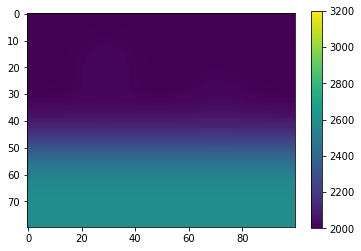

In [18]:
vmodel_smooth = skimage.filters.gaussian(vmodel, 9)
r_smooth = vmodel_smooth*dt/dx

#display
plt.imshow(vmodel_smooth.T, vmin = im_v.get_clim()[0], vmax = im_v.get_clim()[1]) #use same color scale as for the first image of original model
plt.colorbar()
plt.show()

Прямое моделирование проводится точно так же, как раньше. Единственное отличие в том, что скоростная модель теперь сглаженная.

In [19]:
u_down = np.zeros((np.shape(vmodel_smooth)[0], np.shape(vmodel_smooth)[1], int(tmax/dt)), dtype = float)
for k, tk in enumerate(t_array):
    if k >= 2: # we need to start from step 2 because step 1 and step 0 are initial conditions
        v = u_down[:,:,k-1]
        w = u_down[:,:,k-2]
        
        u = solve_fd2d_abc(v, w, vmodel_smooth, r_smooth, dt, dx, dz)

        if k < len(wav1): # if source is active, add its amplitudes to the wavefield
            u[isx, isz] = u[isx, isz] + wav1[k]

        u_down[:,:,k] = u

#### 2. Считаем поле восходящих волн. Поле приемников

Тут на каждом шаге вместо функции источника надо добавлять амплитуды с ранее полученной сейсмограммы

In [20]:
u_up = np.zeros((np.shape(vmodel_smooth)[0], np.shape(vmodel_smooth)[1], int(tmax/dt)), dtype = float)
for k, tk in enumerate(t_array):
    if k >= 2: # we need to start from step 2 because step 1 and step 0 are initial conditions
        v = u_up[:,:,k-1]
        w = u_up[:,:,k-2]
        
        u = solve_fd2d_abc(v, w, vmodel_smooth, r_smooth, dt, dx, dz)
        
        # Instead of source, add amplitudes of the recorded gather
        u[:, 0] = u[:, 0] + muted_gather[:,-(k-1)]

        u_up[:,:,k] = u

#### 3. Считаем взаимную корреляцию, получаем изображение

На самом деле, поскольку нас интересует взаимная корреляция только на нулевом сдвиге по времени, достаточно просто перемножать на каждом шаге снимки полей падающих и восходящих волн. Просуммируем результаты, полученные на каждом шаге... и всё.

In [21]:
migrated_image = np.zeros_like(u_up[:,:,0], dtype = float)
for i in xrange(np.shape(migrated_image)[0]):
    for j in xrange(np.shape(migrated_image)[1]):
        migrated_image[i, j] = np.sum(u_up[i, j, :]*u_down[i, j, ::-1])

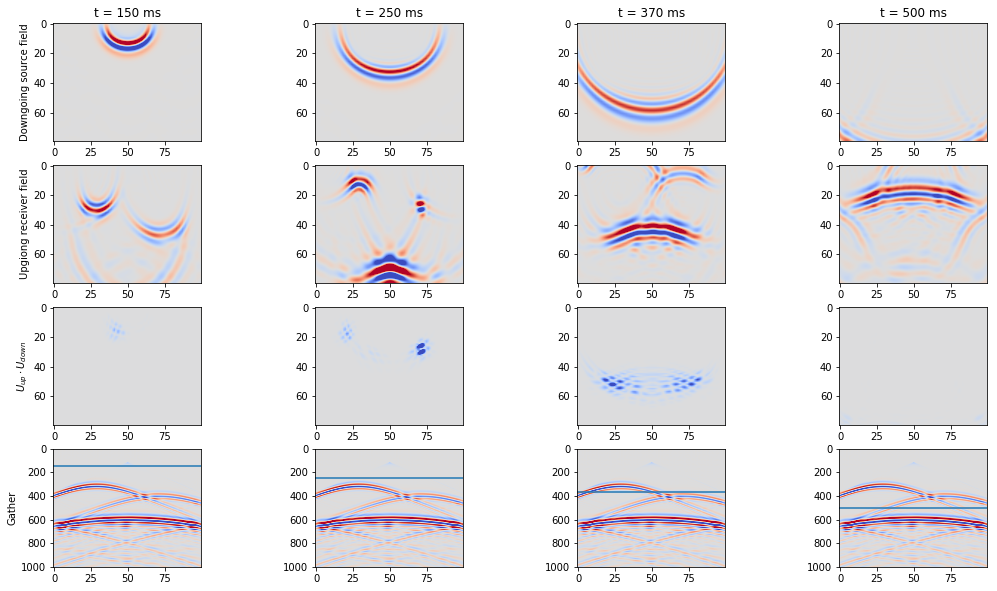

In [30]:
#display

fgr4, axs4 = plt.subplots(4,len(iterations_to_show), figsize = (18,10))

for j, t_iter in enumerate(iterations_to_show):
    axs4[0,0].set_ylabel("Downgoing source field")
    axs4[0,j].set_title("t = {0} ms".format(t_iter))
    axs4[0,j].imshow(u_down[:, :, t_iter].T, cmap = 'coolwarm_r', vmin = -1, vmax = 1, interpolation='bilinear', aspect = 1)
    axs4[1,0].set_ylabel("Upgiong receiver field")
    axs4[1,j].imshow(u_up[:, :, -t_iter].T, cmap = 'coolwarm_r', vmin = -4, vmax = 4, interpolation='bilinear', aspect = 1)
    axs4[2,0].set_ylabel(r"$U_{up} \cdot U_{down}$")
    axs4[2,j].imshow(abs((u_up[:, :, -t_iter].T * u_down[:, :, t_iter].T)), cmap = 'coolwarm_r', vmin = -2, vmax = 2, interpolation='bilinear', aspect = 1)
    axs4[3,0].set_ylabel("Gather")
    axs4[3,j].imshow(muted_gather.T, cmap = 'coolwarm_r', vmin = -0.1, vmax = 0.1, interpolation='bilinear', aspect = nz/(tmax/dt))
    axs4[3,j].axhline(t_iter)
plt.show()

Ок, посмотрим в виде анимации. Если не воспроизводится - смотрите по [ ссылке(24 МБ)](https://github.com/antongrin/rtm-migration-tutorial/blob/master/rtm_animation.gif):
![](https://github.com/antongrin/rtm-migration-tutorial/blob/master/rtm_animation.gif?raw=true)

Ну и посмотрим, что у нас получилось

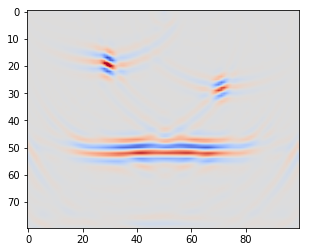

In [23]:
plt.imshow(migrated_image.T,cmap = 'coolwarm_r', vmin = -150, vmax = 150, interpolation='bilinear')
plt.show()

Ого, какая красота. 

Это мы отмигрировали только *одну сейсмограмму* ОПВ, полученную только от одного источника.
Было бы больше источников - они бы охарактеризовали большую часть среды, в том числе по краям (и отражающие элементы были бы подсвечены со всех сторон).

![](https://pbs.twimg.com/media/Bid4nbfCMAAno6e.png)